## Loan Repayment Predict 貸款償還預測
- 來自LendingClub.com的公開數據。
- 作為投資者，你會想投資那些表現出高概率償還你的人。
- 分類並預測借款人是否全額償還貸款。

### 預測
- 是否全額償還貸款 (not fully paid)

### 特徵定義
- credit.policy
    - 如果客戶符合LendingClub.com的信用承保標準則為 1 ，否則為 0。
- purpose
    - 貸款的目的（取值“信用卡式”，“債務重組”，“教育”，“重大收購”，“小生意”，和“所有其他”）。
- int.rate
    - 貸款的利率為期（11％寫作為0.11）。風險較高的借款人將獲得更高的利率
- installment
    - 如果貸款已獲得資金，則借款人所欠的每月分期付款。.
- log.annual.inc
    - 自我報告的借款人年收入的記錄.
- dti
    - 借款人的債務與收入比率（債務金額除以年收入）。
- fico
    - 借款人的FICO信用評分.
- days.with.cr.line
    - 借款人擁有信用額度的天數。
- revol.bal
    - 借款人的週轉金餘額（信用卡結算週期結束時未付的金額）.
- revol.util
    - 借款人的週轉線利用率（相對於可用總額使用的信用額度的數量）。
- inq.last.6mths
    - 借款人在過去6個月內債權人查詢的次數。
- delinq.2yrs
    - 借款人在過去2年中逾期30天以上的還款次數。
- pub.rec
    - 借款人的貶損性公共記錄（破產申請、稅收留置權或判決）的數量。
- not.fully.paid
    - 沒有全額償還貸款 

In [299]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
pd.set_option('display.precision', 2)

In [300]:
# 載入資料集
dataset = pd.read_csv('./data/Loan Repayment Predict/Loan_Repayment_Predict.csv')
dataset.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.1,11.35040654,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.08214255,14.29,707,2760.0,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.37349118,11.63,682,4710.0,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.35040654,8.1,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.29973224,14.97,667,4066.0,4740,39.5,0,1,0,0


#### 觀察資料

In [301]:
# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


#### 缺失值 Missing Value 檢查

Text(0.5, 1.0, 'Total Missing Value (%) in Dataset')

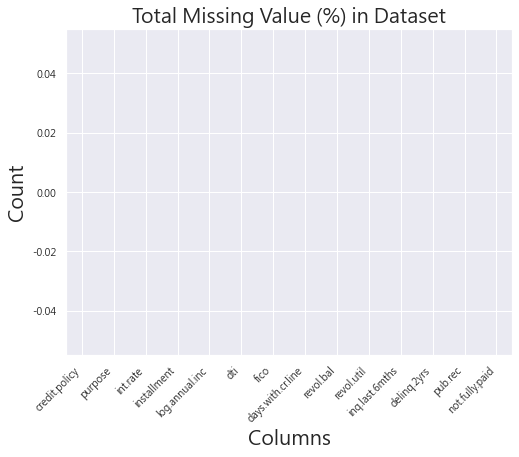

In [302]:
# 檢查缺失值
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Dataset", fontsize = 20)

#### 異常值檢查與處理 outlier
> - 先用 displot 與 catplot 觀察資料分布
> - 無明顯異常值，boxplot上的異常值均屬正常範圍
> - revol.bal :週轉金餘額有三筆資料過大，貸款內容為小生意，有可能金額較大, 因這三筆影響判斷因此刪除

In [303]:
dataset.describe().round(1)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0,9578.0
mean,0.8,0.1,319.1,10.9,12.6,710.8,4560.8,16914.0,46.8,1.6,0.2,0.1,0.2
std,0.4,0.0,207.1,0.6,6.9,38.0,2496.9,33756.2,29.0,2.2,0.5,0.3,0.4
min,0.0,0.1,15.7,7.5,0.0,612.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.1,163.8,10.6,7.2,682.0,2820.0,3187.0,22.6,0.0,0.0,0.0,0.0
50%,1.0,0.1,269.0,10.9,12.7,707.0,4140.0,8596.0,46.3,1.0,0.0,0.0,0.0
75%,1.0,0.1,432.8,11.3,18.0,737.0,5730.0,18249.5,70.9,2.0,0.0,0.0,0.0
max,1.0,0.2,940.1,14.5,30.0,827.0,17640.0,1207359.0,119.0,33.0,13.0,5.0,1.0


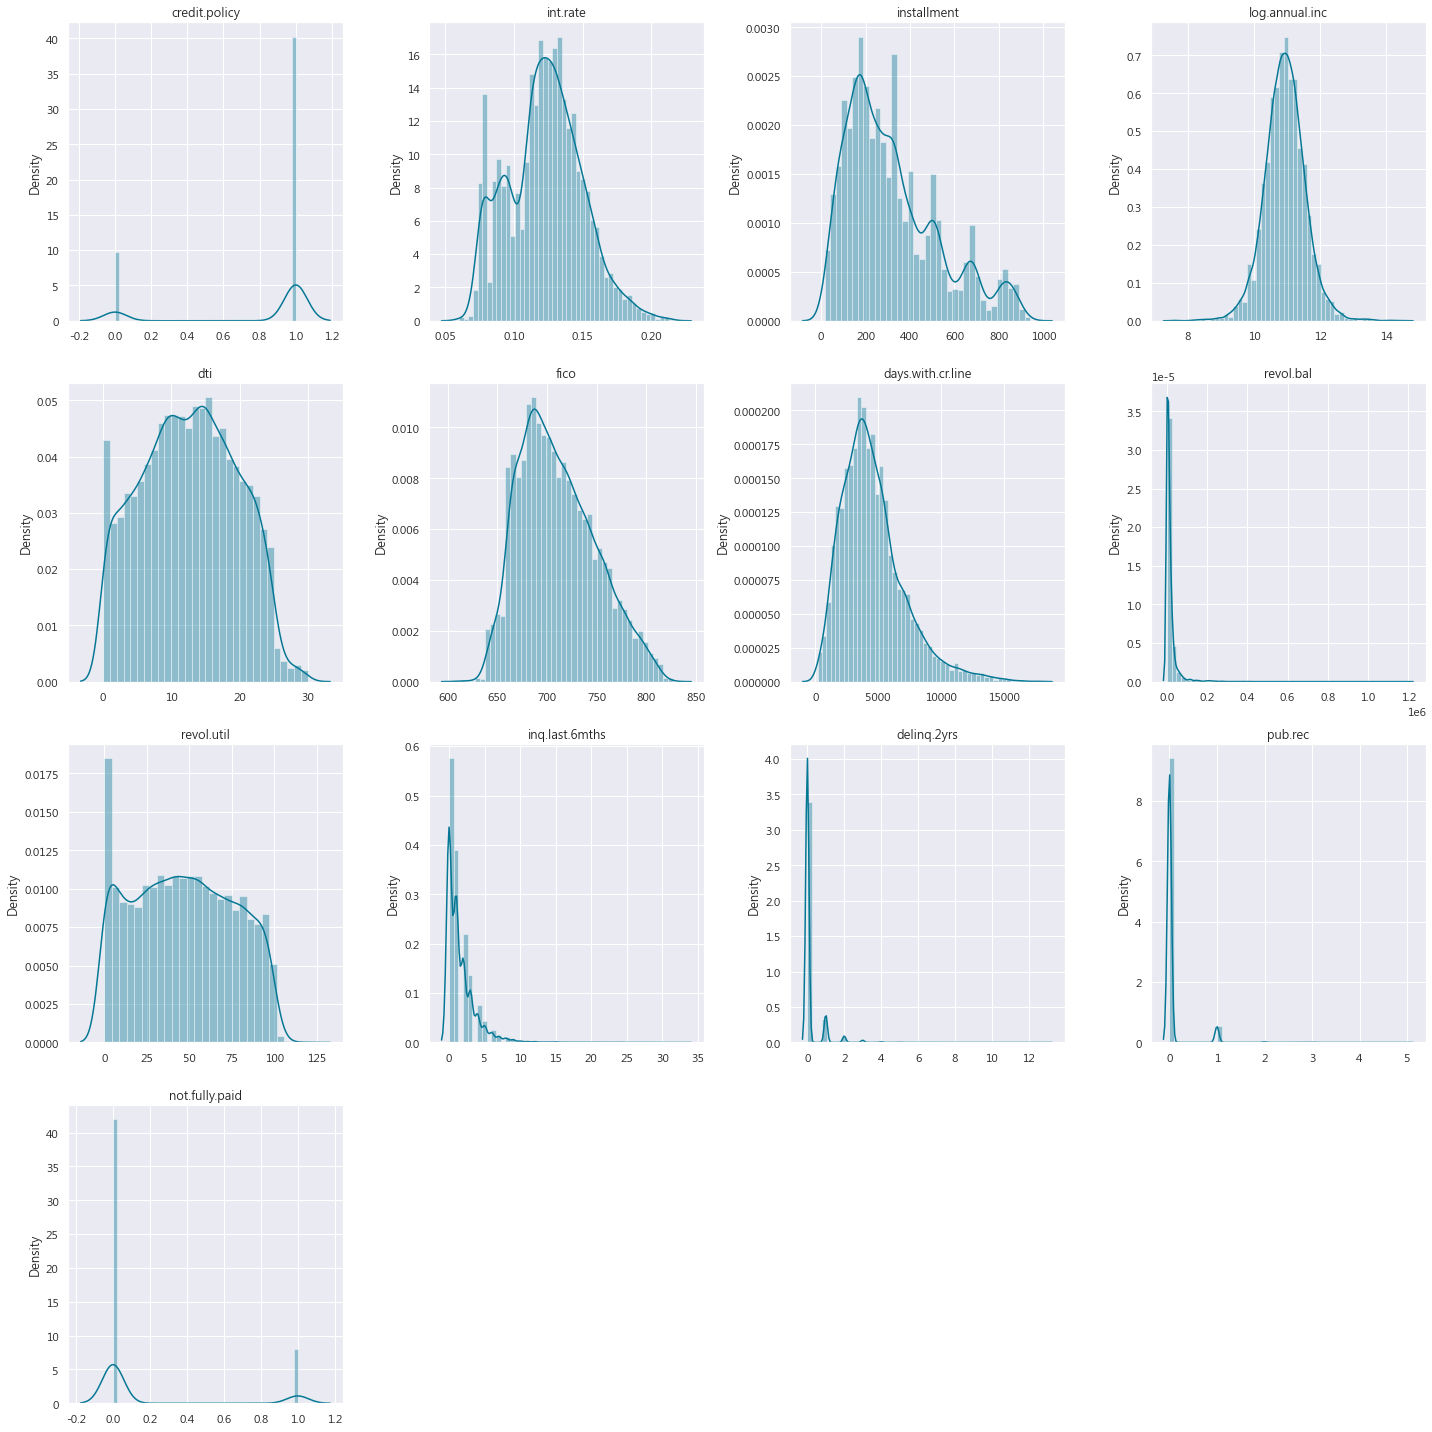

In [304]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

# 觀察所有人的核密度直方圖 查看分布
plt.figure(figsize=(20,20))
for i, source in enumerate(feature_numerical):
    # 指定好子圖的位置 
    plt.subplot(4, 4, i+1)
    # distplot
    sns.distplot(dataset[source], color = '#047794').set(xlabel=None)
    plt.title(source)
    
    plt.tight_layout(h_pad=1)
plt.show()

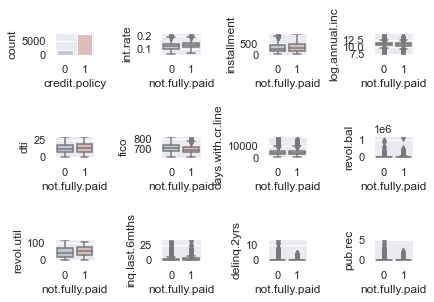

In [305]:
fig, axes = plt.subplots(3,4)
sns.set(rc={'figure.figsize':(15, 15)})
sns.countplot(x = "credit.policy", data=dataset, ax = axes[0,0], palette="vlag")
sns.boxplot(x = "not.fully.paid", y = "int.rate", data = dataset, ax = axes[0,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "installment", data = dataset, ax = axes[0,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "log.annual.inc", data = dataset, ax = axes[0,3], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "dti", data = dataset, ax = axes[1,0], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "fico", data = dataset, ax = axes[1,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "days.with.cr.line", data = dataset, ax = axes[1,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "revol.bal", data = dataset, ax = axes[1,3], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "revol.util", data = dataset, ax = axes[2,0], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "inq.last.6mths", data = dataset, ax = axes[2,1], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "delinq.2yrs", data = dataset, ax = axes[2,2], palette='vlag')
sns.boxplot(x = "not.fully.paid", y = "pub.rec", data = dataset, ax = axes[2,3], palette='vlag')
plt.tight_layout(h_pad=3)

In [306]:
# 移除借款人的週轉金餘額超過60000的異常值
dataset= dataset.drop(dataset[dataset['revol.bal'] > 60000].index)

### EDA (Exploratory Data Analysis) 探索式資料分析 (數值特徵)
> - 先用 displot 與 describe 觀察資料分布  
> - 符合LendingClub.com的信用承保標準的客戶明顯還款機率高
> - 利率越低, 還款機率越高，大概10% 以下的還款機率都很高
> - 每月分期付款介於100~300的人還款機率高
> - 年收入與還款機率沒有太明顯的關係
> - 借款人的債務與收入比率 越低, 還款機率越高, 這是必然的
> - 信用評分越高, 還款機率越高, 超過720就是正的
> - 借款人擁有信用額度的天數 與還款沒有太大的關係
> - 借款人的週轉金餘額越低, 似乎還款機率較高
> - 借款人的週轉線利用率越低, 還款機率越高
> - 過去6個月內債權人查詢的次數越低, 還款機率越高
> - 逾期30天以上的還款次數越高 還款機率越低, 但超過4次後均還款了, 可能是樣本數過低
> - 貶損性公共記錄（破產申請、稅收留置權或判決）的數量越低還款機率越高

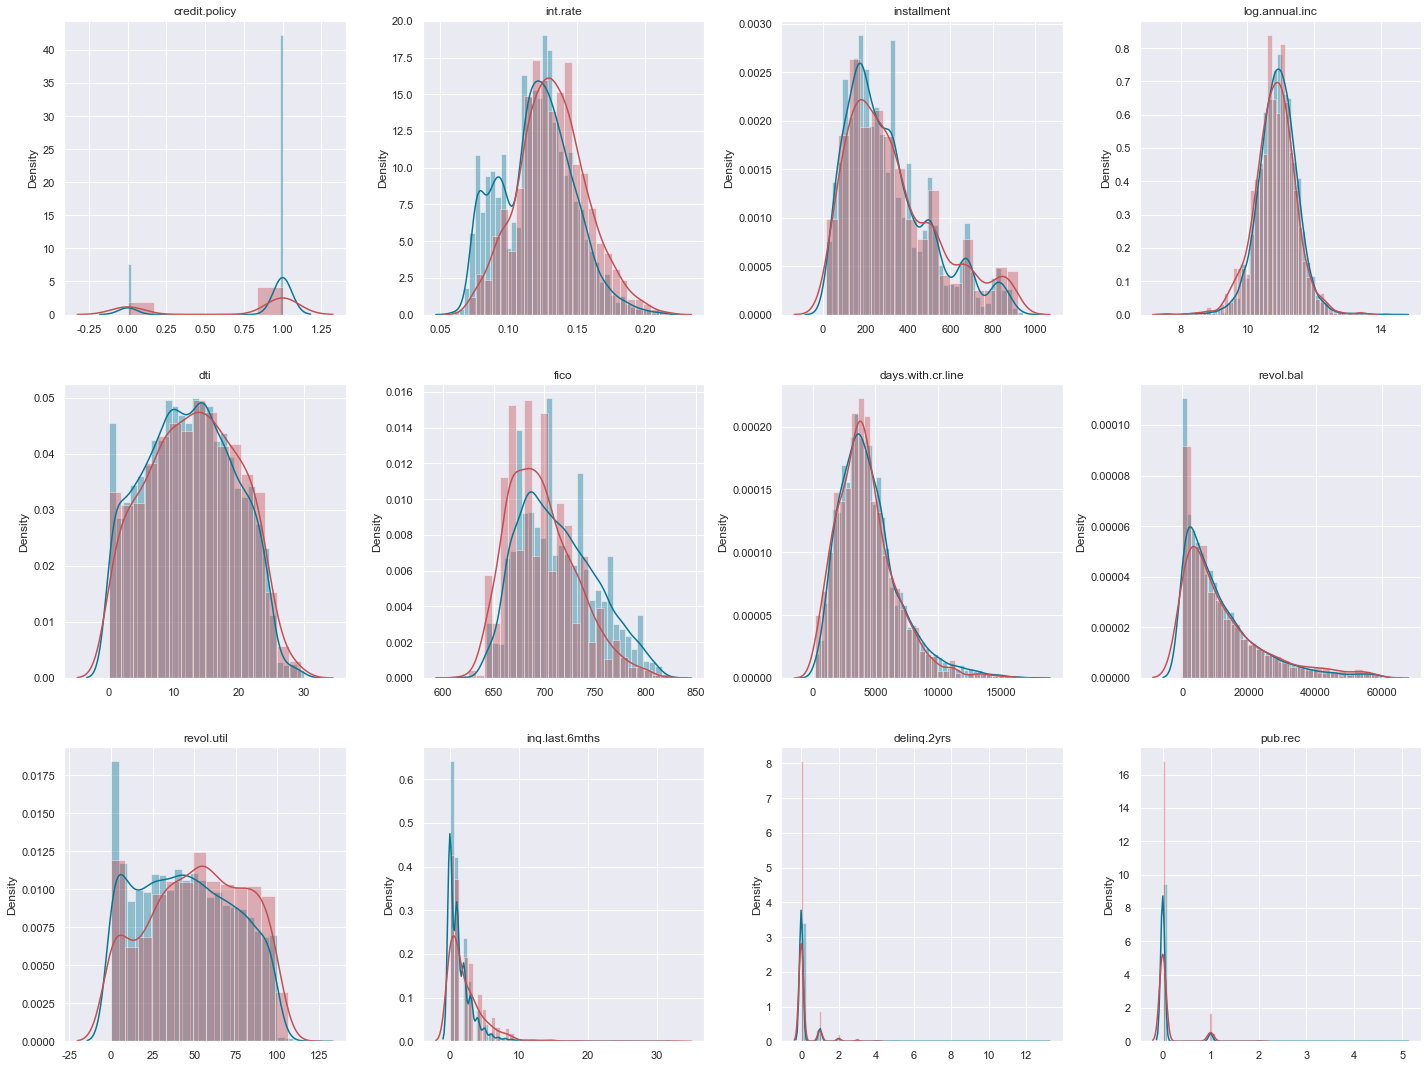

In [307]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

# 觀察數值類型的特徵
plt.figure(figsize=(20,15))
# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(feature_numerical):
    if source == 'not.fully.paid':
        continue
    # 指定好子圖的位置 
    plt.subplot(3, 4, i+1)
    # kdeplot
    sns.distplot(dataset.loc[dataset['not.fully.paid']==0, source], color = '#047794').set(xlabel=None)
    sns.distplot(dataset.loc[dataset['not.fully.paid']==1, source], color = 'r').set(xlabel=None)
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()      

### EDA (Exploratory Data Analysis) 探索式資料分析 (類別特徵)
> - 貸款用途中，還款率最高的為債務合併 85%，最低的為小生意 73.52%

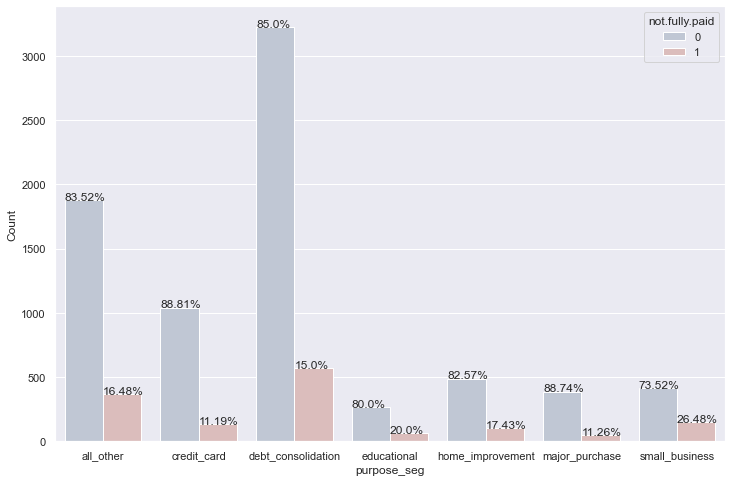

In [308]:
# 針對貸款目的特徵做一次分析 : 
df_purpose = dataset.copy()
df_purpose['purpose_seg'] = np.where(dataset['purpose'] == 'debt_consolidation', 'debt_consolidation',
                            np.where(dataset['purpose'] == 'credit_card', 'credit_card',
                            np.where(dataset['purpose'] == 'all_other', 'all_other',
                            np.where(dataset['purpose'] == 'small_business', 'small_business',
                            np.where(dataset['purpose'] == 'home_improvement', 'home_improvement',
                            np.where(dataset['purpose'] == 'educational', 'educational',
                             'major_purchase'))))))    
# 統計相對應的人數
df_purpose = df_purpose.groupby(['purpose_seg', 'not.fully.paid']).agg({'purpose' : 'count'}).reset_index()
df_purpose.columns = ['purpose_seg','not.fully.paid','count']

plt.figure(figsize=(12,8))
sns.barplot(data = df_purpose, x = 'purpose_seg', y = 'count', hue = 'not.fully.paid', palette = 'vlag')
plt.ylabel('Count')

# 建立百分比標籤
df_purpose['total_user'] = df_purpose.groupby(['purpose_seg'])['count'].transform('sum')
df_purpose['Percentage'] = round(df_purpose['count']/df_purpose['total_user']*100,2).astype(str)+'%'

x_position = -0.4
for i in range(df_purpose['Percentage'].count()):
    plt.text(x = x_position , y = df_purpose['count'][i], s = df_purpose['Percentage'][i], fontsize = 12)
    if i % 2 != 0:
        x_position = x_position + 0.6
    else:
        x_position = x_position + 0.4



### EDA (Exploratory Data Analysis) 探索式資料分析 (特別關注)
> - 信用分數 v.s. 還款率 : 600~650的客戶信用真的明顯很差
> - 信用分數 v.s. 利率 : 信用分數越高立
> - 信用分數 v.s. 借款人擁有信用額度的天數

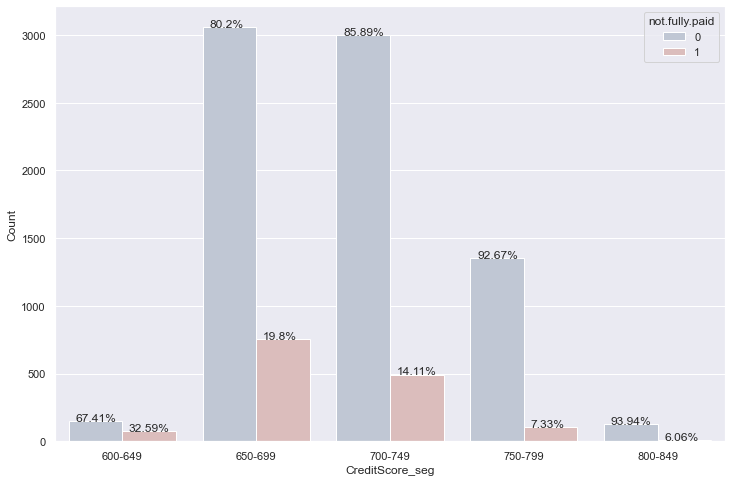

In [309]:
# 針對信用分數特徵再做一次分析 : 
df_CreditScore = dataset.copy()
# 新增信用分數區間特徵
df_CreditScore['CreditScore_seg'] = np.where(dataset['fico'] <= 600, '0-600',
                                    np.where(dataset['fico'] <= 649, '600-649',
                                    np.where(dataset['fico'] <= 699, '650-699',
                                    np.where(dataset['fico'] <= 749, '700-749',
                                    np.where(dataset['fico'] <= 799, '750-799',
                                    np.where(dataset['fico'] <= 849, '800-849',
                                     '900++'))))))              
# 統計相對應的人數
df_CreditScore = df_CreditScore.groupby(['CreditScore_seg', 'not.fully.paid']).agg({'fico' : 'count'}).reset_index()
df_CreditScore.columns = ['CreditScore_seg','not.fully.paid','count']

plt.figure(figsize=(12,8))
sns.barplot(data = df_CreditScore, x = 'CreditScore_seg', y = 'count', hue = 'not.fully.paid', palette = 'vlag')
plt.ylabel('Count')

# 建立百分比標籤
df_CreditScore['total_user'] = df_CreditScore.groupby(['CreditScore_seg'])['count'].transform('sum')
df_CreditScore['Percentage'] = round(df_CreditScore['count']/df_CreditScore['total_user']*100,2).astype(str)+'%'

x_position = -0.35
for i in range(df_CreditScore['Percentage'].count()):
    plt.text(x = x_position , y = df_CreditScore['count'][i], s = df_CreditScore['Percentage'][i], fontsize = 12)
    if i % 2 != 0:
        x_position = x_position + 0.6
    else:
        x_position = x_position + 0.4

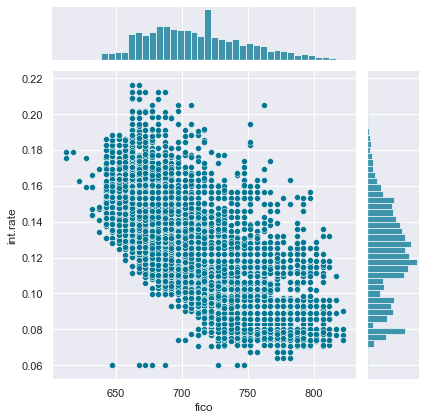

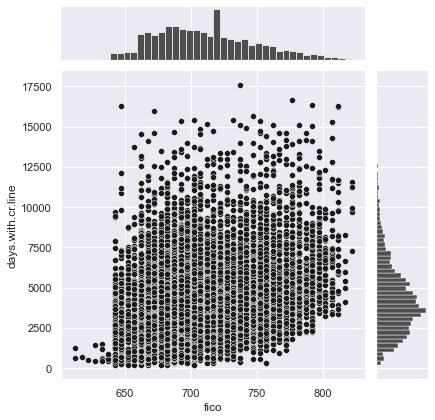

In [310]:
sns.jointplot(x='fico',y='int.rate',data=dataset,color='#047794')
sns.jointplot(x='fico',y='days.with.cr.line',data=dataset,color='k')

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關。

### 1. 特徵建構

### 2. 特徵提取

In [311]:
# one-hot-Encoding 類別資料 (國家)
dataset = pd.get_dummies(data = dataset, columns=['purpose'])

dataset.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.1,11.35040654,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.08214255,14.29,707,2760.0,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.37349118,11.63,682,4710.0,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.35040654,8.1,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.29973224,14.97,667,4066.0,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


### 3. 特徵選擇

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

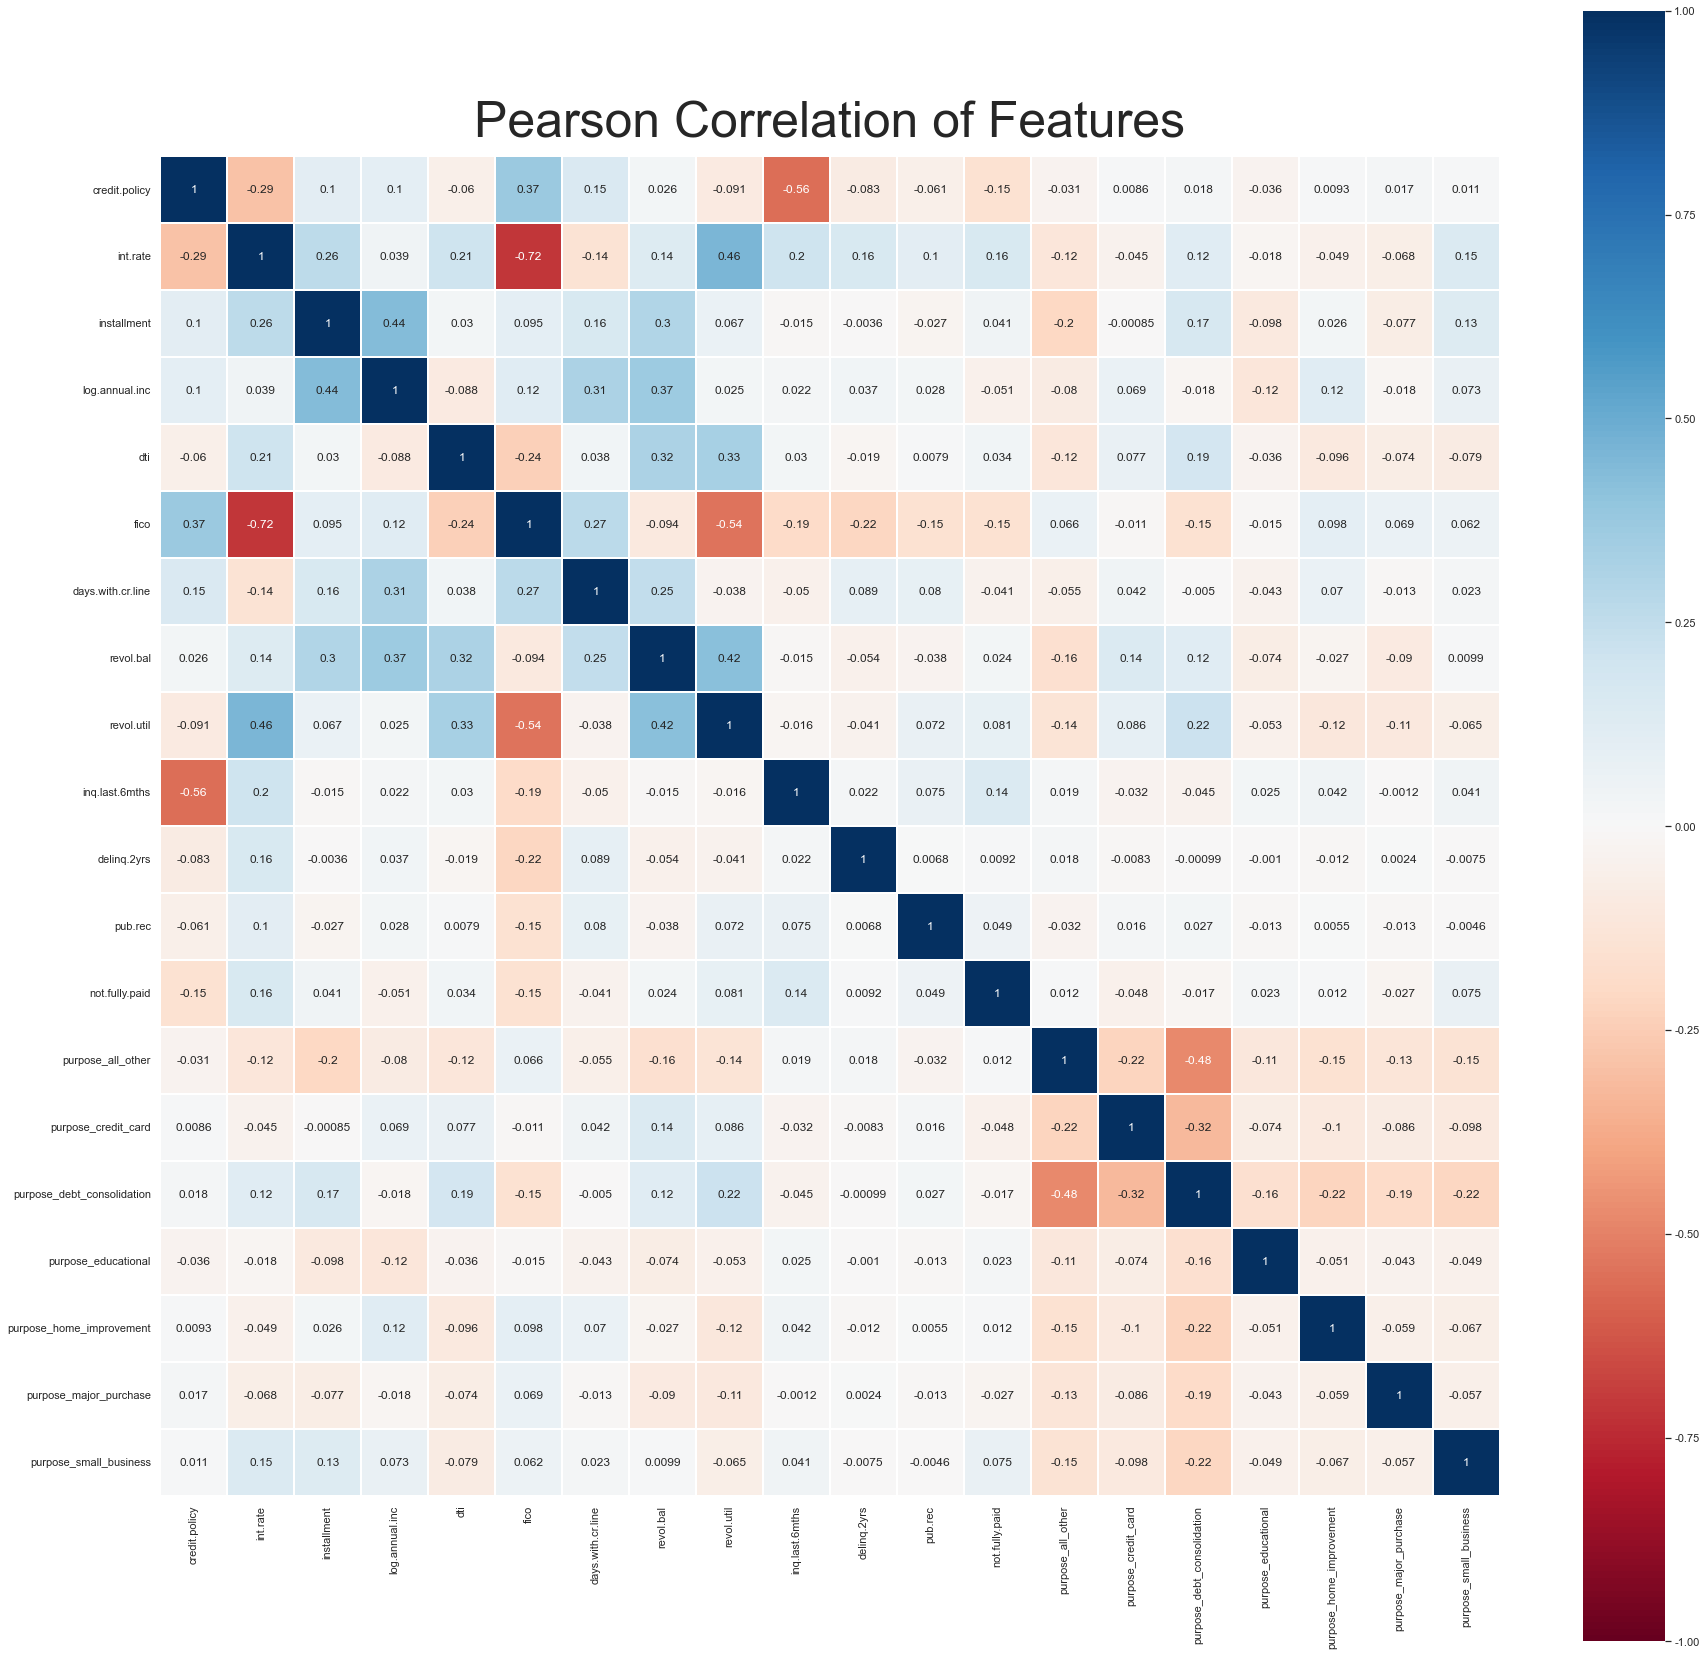

In [312]:
# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(dataset.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

In [313]:
# 觀察相關性
dataset.astype(float).corr()['not.fully.paid'].sort_values()

credit.policy                  -0.1524487855551574
fico                           -0.1514085248005517
log.annual.inc               -0.051352624578655436
purpose_credit_card            -0.0479608796726191
days.with.cr.line             -0.04075367830048682
purpose_major_purchase        -0.02749099125514072
purpose_debt_consolidation   -0.017079981096477504
delinq.2yrs                   0.009206990020145207
purpose_all_other             0.011645556626228926
purpose_home_improvement      0.012208738372301027
purpose_educational           0.022667628599010364
revol.bal                     0.023808195782388162
dti                           0.033645835570470024
installment                    0.04123517466526459
pub.rec                        0.04920871727833366
purpose_small_business         0.07532378766762676
revol.util                     0.08109888364552051
inq.last.6mths                 0.14419099937157803
int.rate                       0.15812660148221294
not.fully.paid                 

## 準備訓練資料

In [314]:
# 訓練資料處理
y = dataset['not.fully.paid']
X = dataset.drop(['not.fully.paid'], axis = 1) # 刪除指定column

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (9124, 19)
y shape: (9124,)


In [315]:
# 將資料分割成訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# 特徵縮放 StandardScaler, MinMaxScaler, RobustScaler 
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_StandardScaler = pd.DataFrame(X_train)
X_train_StandardScaler.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.25885558583106255,-0.27816055750226376,-0.05150897273200903,-0.6454630495790458,-0.09090909090909091,-0.7227380757033126,-0.145985401459854,0.6055612770339855,-0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.1471389645776568,-0.654513957242411,-0.3102997017184834,0.5144995322731526,0.6363636363636364,-0.754653754771302,-0.5435497900987103,-0.7085478887744594,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-0.25885558583106255,-0.5317532186306546,0.41263044871050963,-0.3414405986903648,0.6363636363636364,1.5092779850891747,0.6852237056087137,-0.525231719876416,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.44686648501362436,1.636127406590811,1.6564125978673419,-0.3030869971936389,-0.2727272727272727,0.6398488359321712,0.37328391513180287,0.6055612770339855,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,-0.7874659400544959,-0.4204102523721405,-0.842882341617738,0.1627689429373246,1.0,0.5208219542645286,-0.49846828788623726,-0.7950566426364573,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [316]:
model_LogisticRegression = LogisticRegression()

# 先對模型做交叉驗證，並找出最佳參數
parameters = {
               'C':[0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
               'max_iter':[1, 5, 10, 100, 500, 1000, 5000, 10000, 50000, 100000]
             }
model_LogisticRegression_grid = GridSearchCV(model_LogisticRegression, parameters, cv=10, verbose=1, n_jobs=-1).fit(X_train,y_train)
model_LogisticRegression_grid.best_params_

model_LogisticRegression = LogisticRegression(random_state=42, C = model_LogisticRegression_grid.best_params_['C'], max_iter = model_LogisticRegression_grid.best_params_['max_iter'])
model_LogisticRegression.fit(X_train,y_train)
print('Logistic Regression Training score:', model_LogisticRegression.score(X_train, y_train)*100)

#測試測試集
y_test_predict = model_LogisticRegression.predict(X_test)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_test, y_test_predict)

print(classification_report(y_test, y_test_predict))
# AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_test_predict)))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Logistic Regression Training score: 84.43622414029319
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1525
           1       0.00      0.00      0.00       300

    accuracy                           0.84      1825
   macro avg       0.42      0.50      0.46      1825
weighted avg       0.70      0.84      0.76      1825

AUC: 0.5000



### 2. Random Forest 隨機森林

In [317]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_test_predict = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)

print(classification_report(y_test, y_test_predict))
# AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_test_predict)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1525
           1       0.60      0.02      0.04       300

    accuracy                           0.84      1825
   macro avg       0.72      0.51      0.47      1825
weighted avg       0.80      0.84      0.77      1825

AUC: 0.5087



### 3. LightGBM 

In [318]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)
y_test_predict = model_lgb.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)

print(classification_report(y_test, y_test_predict))
# AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_test_predict)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1525
           1       0.44      0.05      0.08       300

    accuracy                           0.83      1825
   macro avg       0.64      0.52      0.50      1825
weighted avg       0.77      0.83      0.77      1825

AUC: 0.5174



### 2. ANN 神經網路

In [319]:
# 初始化 ANN 神經網路
classifier = Sequential()  # 初始化神經網路
 
# 建立 6 個隱藏層, 使用 relu 激勵函數, 隨機初始化權重, 並註明輸入層為 19 個神經元(因為有 19 個特徵)
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform', input_dim = 19))   

# 再加一個隱藏層 複製上一行, 不須再註明 input layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform')) 

# 添加輸出層 (若輸出的類別大於 2 , 例如有三種輸出 , 則 units = 3 , activation = softmax (sigmoid的多類別激勵函數))
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))

# 要先編譯神經網路 (定義損失函數，建立隨機梯度下降，學習率 ) ==> 對模型做些配置
# 若分類結果為0,1: loss = 'binary_crossentropy', 大於2: loss =  categorical_crossentropy
# metrics 用來判斷模型標準 , 使用 accuracy 來判斷準確度
classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

# 訓練模型 , 
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
730/730 [==============================] - 1s 941us/step - loss: 0.4708 - accuracy: 0.8440
Epoch 2/100
730/730 [==============================] - 1s 996us/step - loss: 0.4085 - accuracy: 0.8444
Epoch 3/100
730/730 [==============================] - 1s 978us/step - loss: 0.4058 - accuracy: 0.8444
Epoch 4/100
730/730 [==============================] - 1s 797us/step - loss: 0.4049 - accuracy: 0.8444
Epoch 5/100
730/730 [==============================] - 1s 753us/step - loss: 0.4044 - accuracy: 0.8444
Epoch 6/100
730/730 [==============================] - 0s 612us/step - loss: 0.4040 - accuracy: 0.8444
Epoch 7/100
730/730 [==============================] - 0s 623us/step - loss: 0.4036 - accuracy: 0.8444
Epoch 8/100
730/730 [==============================] - 1s 734us/step - loss: 0.4030 - accuracy: 0.8444
Epoch 9/100
730/730 [==============================] - 1s 697us/step - loss: 0.4030 - accuracy: 0.8444
Epoch 10/100
730/730 [==============================] - 1s 723us/step - l

In [320]:
# 預測結果
y_test_predict = classifier.predict(X_test)
y_test_predict
# 將預測機率大於 0.5 個設成 TRUE , 代表會離開銀行, 小於 0.5 的就為 FALSE , 代表會留在銀行
y_test_predict = (y_test_predict > 0.5)
cm = confusion_matrix(y_test, y_test_predict)

print(classification_report(y_test, y_test_predict))
# AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_test_predict)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1525
           1       0.45      0.02      0.03       300

    accuracy                           0.84      1825
   macro avg       0.65      0.51      0.47      1825
weighted avg       0.77      0.84      0.77      1825

AUC: 0.5064

